### Importações das bibliotecas


In [1]:
import datetime

# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# divisão em folds, feature scaling, feature selection e feature encoding
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE

# métricas de performance de modelos
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# importando RandomForestClassifier e GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna
import optuna.logging
# Definindo que apenas os avisos serão exibidos, para evitar spam nos outputs.
optuna.logging.set_verbosity(optuna.logging.WARNING)

g:\Program Files (x86)\Python 3 11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importando a base de dados

In [2]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

In [3]:
# Treina o modelo, exibe precisão/recall/f1-score, matriz de confusão,
# feature_importance e 
# retorna o modelo treinado, X_test, y_test, y_pred
def treinar_modelo(modelo, X: pd.DataFrame, y: pd.Series, metrics_report: bool=False, feature_importance_report: bool=False) -> Pipeline:      
    # Criando o StratifiedKFold com 10 folds
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']

    # Definindo um pipeline com StandardScaler, TargetEncoder e o modelo
    pipeline = Pipeline([
        ('encoder', TargetEncoder(cols=cat_features)),
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Definindo as métricas de avaliação do modelo
    scoring = [
        'precision_weighted',
        'recall_weighted',
        'f1_weighted'
               ]
        
    # Calculando as métricas usando cross_validate
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        
    # Separando os folds
    train_index, test_index = next(skf.split(X,y))
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Treinamos a pipeline
    pipeline.fit(X_train, y_train)
    
    # Obtemos os resultados da previsão para aplicar nas funções das métricas
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    
    # pr_auc: Precision-Recall Area Under the Curve
    precisao, revocacao, limiares = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(revocacao, precisao)
    
            
    # Exibe métricas e matriz de confusão
    if metrics_report:
            # Exibindo as métricas
            print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.2%}")
            print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.2%}")
            print(f"Média do F1 Score (Weighted): {scores['test_f1_weighted'].mean():.2%}")
            print(f'Precisão x Revocação, Área abaixo da Curva: ({pr_auc:.2%}) -> {pr_auc:.16f}')
        
            # Plotando a matriz de confusão da cross_validate
            matriz_confusao = confusion_matrix(y_test, y_pred)
            sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Greens')

            # Configurações do gráfico
            plt.title('Matriz de confusão')
            plt.xlabel('Valor Predito')
            plt.ylabel('Valor Real')
            plt.show();    

    # Exibe a feature importance
    if feature_importance_report:
        if hasattr(pipeline.named_steps['modelo'], 'feature_importances_'):
            feature_importances = pipeline.named_steps['modelo'].feature_importances_
            importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
            importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
            print(importances_df)
            
    return pipeline, X_test, y_test, y_pred

In [4]:
# Relatório do Recursive Feature Elimination
def rfe_report(modelo, min_range: int=13, max_range: int=23) -> list:
    # splitar em treino e teste estratificado
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=47)

    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']
    
    # Loop sobre os folds do StratifiedKFold para obter os splits estratificados
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        # Instanciamos o Encoder
        encoder = TargetEncoder(min_samples_leaf=450, smoothing=11.5, cols=cat_features)
        
        # Ajustando o encoder apenas ao conjunto de treinamento
        encoder.fit(X_train[cat_features], y_train)
        
        # Aplicamos a transformação tanto no treinamento quanto no teste
        X_train[cat_features] = encoder.transform(X_train[cat_features]).astype(float)
        X_test[cat_features] = encoder.transform(X_test[cat_features]).astype(float)
    
    # instanciamos o RFE
    selector = RFE(estimator=modelo)
    
    # Instanciando variáveis controle da melhor métrica obtida:
    melhor_pr_auc = 0
    
    # iteramos sobre a quantidade de features desejadas para o modelo de 2 em 2
    for qtd_features in range(min_range, max_range, 2):
        # definimos o número de features que devem permanecer
        selector.n_features_to_select = qtd_features

        # Executando RFE no fold de treino
        selector.fit(X_train, y_train)
        features_selecionadas = selector.support_

        # Filtrar as features selecionadas
        X_train_selecionado = X_train.loc[:, features_selecionadas]
        X_test_selecionado = X_test.loc[:, features_selecionadas]

        # Treinar o modelo com as features selecionadas
        modelo.fit(X_train_selecionado, y_train)

        # Prever probabilidades no fold de teste
        y_pred_proba = modelo.predict_proba(X_test_selecionado)[:, 1]

        # Calcular a curva Precision-Recall AUC
        precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
        metrica_pr_auc = auc(revocacao, precisao)
        nome_features_selecionadas = [X_train.columns[i] for i, item in enumerate(features_selecionadas) if item]  
        
        # Comparando e atualizando as informações do melhor resultado encontrado
        if metrica_pr_auc > melhor_pr_auc:         
            melhor_modelo_n_features = qtd_features
            melhores_features = nome_features_selecionadas.copy()
            melhor_pr_auc = metrica_pr_auc
    
        # exibe as informações do RFE atual
        print('----------------------------------------------')
        print(f'RFE {qtd_features} features - [INFO] Precision Recall AUC: ', metrica_pr_auc)
    # exibe as informações do melhor RFE
    print('----------------------------------------------')
    print(f'MELHOR "X_train" com {melhor_modelo_n_features} features:')
    print('[END] Precision Recall AUC: ', melhor_pr_auc)
    print("[END] Features selecionadas: ", melhores_features)
    
    # retorna as features que obtiveram a melhor métrica
    return melhores_features

# Modelagem
### Feature Engineering
Utilizaremos:
- Médias e desvios-padrão de features; e
- ratios: divisão de uma feature por outra

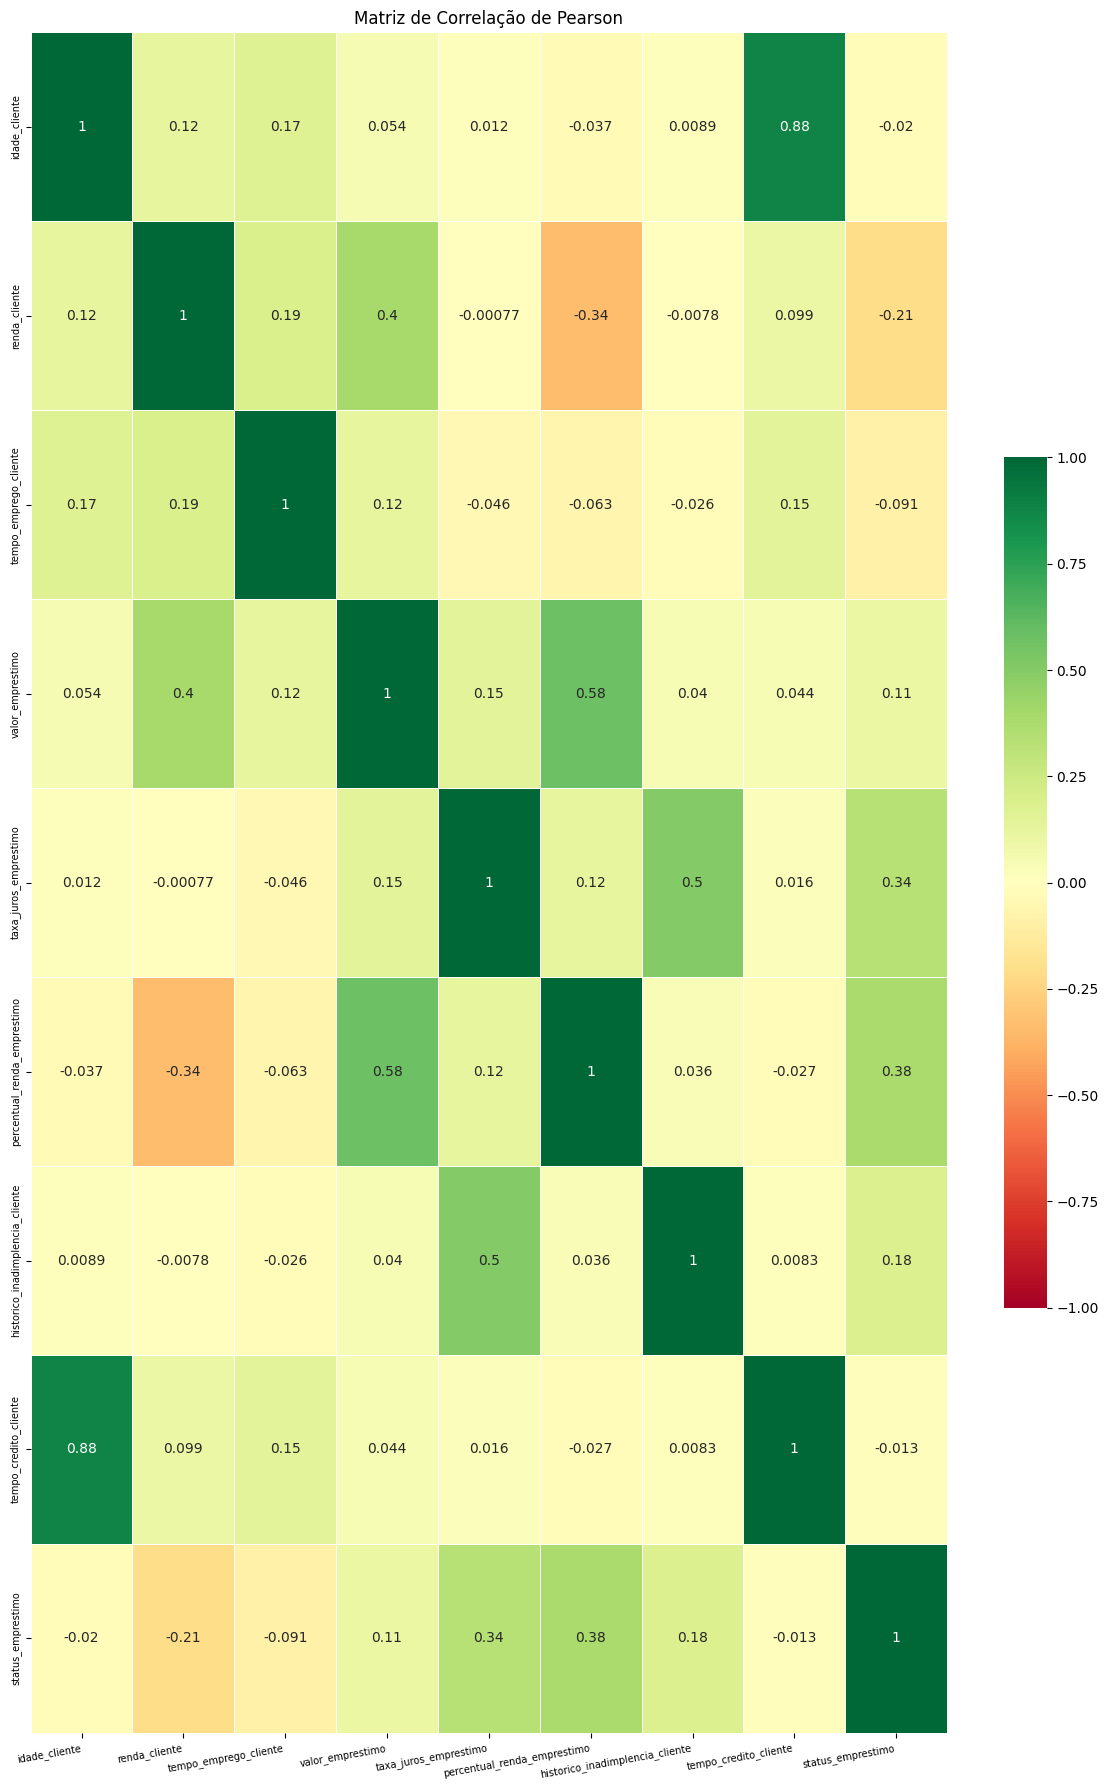

In [11]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz da correlação de Pearson
corr_matrix = df[numeric_cols].corr()

# Exibindo a correlação de Pearson e ajustando os rótulos
sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma correlação positiva moderada entre as variáveis:
- **`idade_cliente`** e **`tempo_credito_cliente`**; e
- **`taxa_juros_emprestimo`** e **`historico_inadimplencia_cliente`**

Criaremos as seguintes features:
 1. retorno_emprestimo = multiplicando (taxa_juros_emprestimo por valor_emprestimo) + valor_empréstimo;
 2. ratio_renda_emp = dividindo renda por emprestimo;
 3. ratio_emprego_credito = tempo_emprego_cliente dividido por tempo_credito_cliente, caso dividir por zero, resulta em zero;
 4. media_valemp_nota = média de valor_emprestimo para cada nota_emprestimo;
 5. media_valoremp_finalidade = média de valor_emprestimo para cada finalidade_emprestimo;
 6. std_valemp_residencia = desvio-padrão do valor_emprestimo por posse_residencia_cliente;
 7. media_renda_nota = média de renda_cliente para cada nota_emprestimo;
 8. media_renda_finalidade = média de renda_cliente para cada finalidade_emprestimo;
 9. std_renda_residencia = desvio-padrão do renda_cliente por posse_residencia_cliente;
10. ratio_emprego_renda = tempo_emprego_cliente dividido por renda_cliente
11. ratio_credito_renda = tempo_credito_cliente dividido por renda_cliente

In [5]:
# 1. 
df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)
# 2.
df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']
# 3. 
df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']
# 4.
df['media_valemp_nota'] = df.groupby(['nota_emprestimo'])['valor_emprestimo'].transform('mean')
# 5.
df['media_valemp_finalidade'] = df.groupby(['finalidade_emprestimo'])['valor_emprestimo'].transform('mean')
# 6.
df['std_valemp_residencia'] = df.groupby(['posse_residencia_cliente'])['valor_emprestimo'].transform('std')
# 7.
df['media_renda_nota'] = df.groupby(['nota_emprestimo'])['renda_cliente'].transform('mean')
# 8.
df['media_renda_finalidade'] = df.groupby(['finalidade_emprestimo'])['renda_cliente'].transform('mean')
# 9.
df['std_renda_residencia'] = df.groupby(['posse_residencia_cliente'])['renda_cliente'].transform('std')
# 10.
df['ratio_emprego_renda'] = df['tempo_emprego_cliente'] / df['renda_cliente']
# 11.
df['ratio_credito_renda'] = df['tempo_credito_cliente'] / df['renda_cliente']

In [6]:
# visualizando o dataset após implementação
df.head(15)

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,Alugada,23,Pessoal,D,35000,16.020000,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
1,21,9600,Própria,5,Educação,B,1000,11.140000,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,Hipoteca,1,Médico,C,5500,12.870000,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
3,23,65500,Alugada,4,Médico,C,35000,15.230000,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,Alugada,8,Médico,C,35000,14.270000,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,Própria,2,Empreendimento,A,2500,7.140000,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,Alugada,8,Educação,B,35000,12.420000,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
7,24,78956,Alugada,5,Médico,B,35000,11.110000,0.44,0,...,2.255886,1.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000063,0.000051
8,24,83000,Alugada,8,Pessoal,A,35000,8.900000,0.42,0,...,2.371429,4.000000,8521.565413,9586.847630,5814.229899,65154.163508,65187.707459,31495.813457,0.000096,0.000024
9,21,10000,Própria,6,Empreendimento,D,1600,14.740000,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300


Ficamos com 23 colunas no total, 11 a mais do que o dataset original.

### Avaliando a performance de modelos e respectivas Feature Importances

In [6]:
# Separamos a variável dependente das independentes
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

Instanciamos a variável target e as variáveis independentes.

In [33]:
# Definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Como a Classe 1 é rara, o modelo Random Forest precisa que seja instanciado a proporção inversa de cada classe, definindo o peso de cada uma.
- Classe 0 -> Peso: 0.6406821745948772
- Classe 1  -> Peso: 2.2770552717138877

Média da Precisão (Weighted): 93.77%
Média da Revocação (Weighted): 93.44%
Média do F1 Score (Weighted): 93.04%
Precisão x Revocação, Área abaixo da Curva: (89.40%) -> 0.8940081147225889


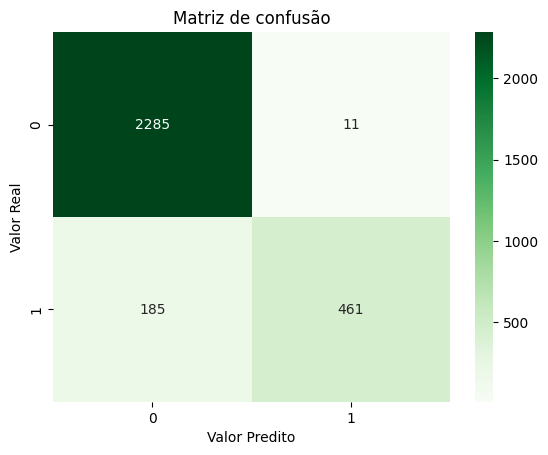

                            Feature  Importance
0                   ratio_renda_emp    0.115611
1       percentual_renda_emprestimo    0.104484
2                     renda_cliente    0.090459
3             taxa_juros_emprestimo    0.074104
4                 media_valemp_nota    0.061561
5                   nota_emprestimo    0.059089
6                retorno_emprestimo    0.050924
7               ratio_credito_renda    0.048328
8             std_valemp_residencia    0.043963
9               ratio_emprego_renda    0.042707
10                 valor_emprestimo    0.038066
11            finalidade_emprestimo    0.037805
12            tempo_emprego_cliente    0.031685
13            ratio_emprego_credito    0.031363
14                    idade_cliente    0.031187
15             std_renda_residencia    0.024389
16           media_renda_finalidade    0.023417
17         posse_residencia_cliente    0.022227
18            tempo_credito_cliente    0.021873
19                 media_renda_nota    0

In [34]:
# Instanciando o modelo random forest com 30 n_estimators, entropia como critério e pesos das classes inversamente proporcionais
randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)
# Treinando o random forest classifier, exibindo métricas e feature importance
rf_treinado, _, _, _  = treinar_modelo(randomforestclassifier, X, y, True, True)

Média da Precisão (Weighted): 93.80%
Média da Revocação (Weighted): 93.53%
Média do F1 Score (Weighted): 93.16%
Precisão x Revocação, Área abaixo da Curva: (90.81%) -> 0.9081230182607759


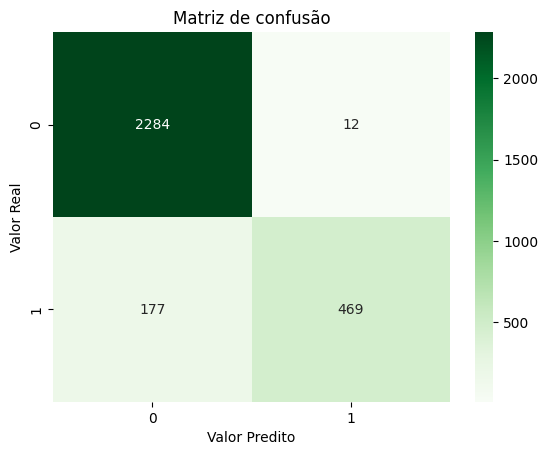

                            Feature  Importance
0                   ratio_renda_emp    0.243214
1                   nota_emprestimo    0.234856
2          posse_residencia_cliente    0.145219
3             tempo_emprego_cliente    0.080451
4             finalidade_emprestimo    0.068420
5                     renda_cliente    0.047948
6       percentual_renda_emprestimo    0.036799
7           media_valemp_finalidade    0.025053
8             taxa_juros_emprestimo    0.020729
9                     idade_cliente    0.019063
10            std_valemp_residencia    0.015410
11              ratio_emprego_renda    0.009339
12               retorno_emprestimo    0.008717
13            ratio_emprego_credito    0.008480
14              ratio_credito_renda    0.008412
15                 valor_emprestimo    0.006890
16            tempo_credito_cliente    0.005155
17                media_valemp_nota    0.004407
18                 media_renda_nota    0.004263
19  historico_inadimplencia_cliente    0

In [8]:
# Instanciando o XGBClassifier
xgbclassifier = XGBClassifier(n_estimators=30, random_state=47)
# Treinando o xgboost, exibindo métricas e feature importance
xgboost_treinado, _, _, _  = treinar_modelo(xgbclassifier, X, y, True, True)

Média da Precisão (Weighted): 92.46%
Média da Revocação (Weighted): 92.21%
Média do F1 Score (Weighted): 91.71%
Precisão x Revocação, Área abaixo da Curva: (86.61%) -> 0.8660841515742700


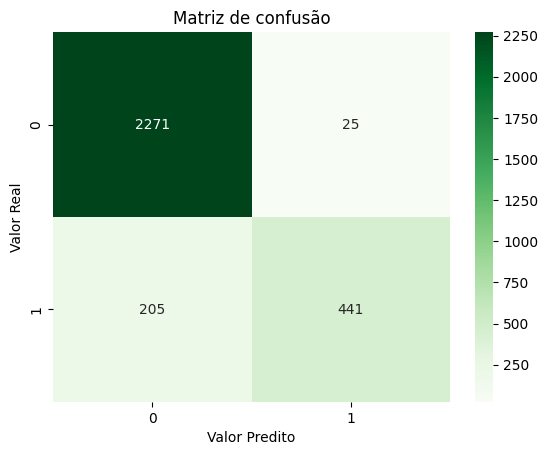

                            Feature  Importance
0                   ratio_renda_emp    0.329896
1                 media_valemp_nota    0.156179
2                   nota_emprestimo    0.112392
3          posse_residencia_cliente    0.100985
4                     renda_cliente    0.097977
5             finalidade_emprestimo    0.065045
6              std_renda_residencia    0.047988
7             std_valemp_residencia    0.035295
8             tempo_emprego_cliente    0.029047
9             taxa_juros_emprestimo    0.010532
10           media_renda_finalidade    0.007819
11      percentual_renda_emprestimo    0.003239
12          media_valemp_finalidade    0.002911
13                 media_renda_nota    0.000697
14                    idade_cliente    0.000000
15              ratio_emprego_renda    0.000000
16               retorno_emprestimo    0.000000
17            ratio_emprego_credito    0.000000
18            tempo_credito_cliente    0.000000
19  historico_inadimplencia_cliente    0

In [35]:
# Instanciando o gradient boosting
gradientboostingclassifier = GradientBoostingClassifier(n_estimators=30, random_state=47)
# treinando o gradient boosting, exibindo métricas e feature importance
gradientboost_treinado, _, _, _  = treinar_modelo(gradientboostingclassifier, X, y, True, True)

### Análise dos modelos e respectivas Features Importances
Para evitar overfitting e capturar ruídos dos dados, preferimos verificar a importância das features em cada modelo e tratar as piores posteriormente. Os modelos foram treinados com 10 folds no StratifiedKFold (SKF) em razão do desbalanceamento de classes, situação em que o SKF lida bem na distribuição de folds em treino e teste estratificando-os.
- Random Forest Classifier:
    - Média da Precisão (Weighted): 93.77%
    - Média da Revocação (Weighted): 93.44%
    - Média do F1 Score (Weighted): 93.04%
    - Precisão x Revocação, Área abaixo da Curva: 89.40%
    - Top 5 Feature Importance:
        - ratio_renda_emp;
        - percentual_renda_emprestimo;
        - renda_cliente;
        - taxa_juros_emprestimo;
        - media_valemp_nota;
    - Nenhuma feature sem importância para o modelo, sendo a menor **`historico_inadimplencia_cliente`** com 0.006285.
- XGBoost Classifier:
    - Média da Precisão (Weighted): 93.80%
    - Média da Revocação (Weighted): 93.53%
    - Média do F1 Score (Weighted): 93.16%
    - Precisão x Revocação, Área abaixo da Curva: 90.81%
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - nota_emprestimo
        - posse_residencia_cliente
        - tempo_emprego_cliente
        - finalidade_emprestimo
    - 1 feature sem importância para o modelo, sendo ela **`std_renda_residencia`**.
- Gradient Boosting Classifier:
    - Média da Precisão (Weighted): 92.46%
    - Média da Revocação (Weighted): 92.21%
    - Média do F1 Score (Weighted): 91.71%
    - Precisão x Revocação, Área abaixo da Curva: 86.61%
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - media_valemp_nota
        - nota_emprestimo
        - posse_residencia_cliente
        - renda_cliente
    - 8 features sem importância para o modelo, sendo 4 delas do DataFrame original.

O modelo que se saiu melhor em termos de minimizar os falsos positivos foi o Random Forest Classifier, contudo, desejamos diminuir o número de clientes inadimplentes que o modelo erra (falsos negativos). Logo o XGBoost Classifier obteve resultados melhores com um custo baixo de falsos positivos.

O modelo com a pior performance foi o Gradient Boosting Classifier.

 ### Feature Selection
- RFE (Recursive Feature Elimination)
    - Testamos a quantidade de features cuja métrica utilizada foi a área abaixo da curva entre precisão e revocação (pr_auc).

In [36]:
# Executando feature selection
_ = rfe_report(randomforestclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8722425380625938
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8737953487529418
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8788923801451417
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8784479150433919
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.878186920325009
----------------------------------------------
MELHOR "X_train" com 17 features:
[END] Precision Recall AUC:  0.8788923801451417
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'std_

No RandomForestClassifier obtemos o melhor resultado com 17 features e pr_auc de: 0.8788923801451417

In [37]:
# Executando segundo feature selection na random forest
features_RFE_randomforest = rfe_report(randomforestclassifier, 18, 23)

----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8775055499060729
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8799720356171663
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8773936820640365
----------------------------------------------
MELHOR "X_train" com 20 features:
[END] Precision Recall AUC:  0.8799720356171663
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'tempo_credito_cliente', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'std_renda_residencia', 'ratio_emprego_renda', 'ratio_credito_renda']


Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no Random Forest, descobrimos que com 20 features a área abaixo da curva é maior com 20 features e pr_auc de: 0.8799720356171663

In [10]:
# Executando feature selection
_ = rfe_report(xgbclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.893648428126721
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8910728906675718
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8925454245892724
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8901604917217762
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8921073840893009
----------------------------------------------
MELHOR "X_train" com 13 features:
[END] Precision Recall AUC:  0.893648428126721
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidad

No XGBClassifier obtemos o melhor resultado com 13 features e pr_auc de: 0.893648428126721

In [11]:
# Executando segundo feature selection no xgboost
features_RFE_xgboost = rfe_report(xgbclassifier, 14, 23)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8938019204177713
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8924420160755078
----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8904229613548036
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8927755492728
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8921073840893009
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8938019204177713
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade

Como o XGBoost Classifier foi o modelo que se saiu melhor nos resultados iniciais, resolvemos fazer mais uma busca nas quantidades de features restantes utilizando o RFE, obtemos um melhor resultado com 14 features e pr_auc de: 0.8938019204177713

In [38]:
# Executando feature selection
features_RFE_gbc = rfe_report(gradientboostingclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8586441590501775
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
MELHOR "X_train" com 13 features:
[END] Precision Recall AUC:  0.8586441590501775
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_r

No GradientBoostingClassifier obtemos o melhor resultado com 13 features e pr_auc de: 0.8586441590501775

In [39]:
# Executando segundo feature selection no gradient boosting
_ = rfe_report(gradientboostingclassifier, 14, 17)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8583505356191692
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8583505356191692
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'std_renda_residencia']


Após verificarmos duas features acima da melhor métrica encontrada no GradientBoost, podemos confirmar que com 13 features a área abaixo da curva é maior.

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna
- Utilizaremos as features selecionadas pelo Recursive Feature Selection.


In [46]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Definindo o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        criterion='entropy',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # Treinando o modelo com as features do RFE e exibir performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_randomforest], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calculando a curva Precision-Recall AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornando o pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [47]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo:", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo: 4:56:35.150571
Melhores hiperparâmetros:  {'n_estimators': 277, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.6610560738295206}


In [41]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # Definindo o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # Treinando o modelo com as features do RFE e exibindo performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_xgboost], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calculando a curva Precision-Recall e AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [13]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no xgboost
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_xgboost = XGBClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  0:04:56.773140
Melhores hiperparâmetros:  {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.14427809782945916, 'gamma': 0.19262826608189895}


In [44]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # Treinando o modelo com as features do RFE e exibindo performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_gbc], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
 
    # Calculando a curva Precision-Recall AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornando pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [45]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_gradient_boost = GradientBoostingClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  3:27:06.995878
Melhores hiperparâmetros:  {'n_estimators': 233, 'max_depth': 7, 'learning_rate': 0.11008445645768045, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 0.9996811582073081}


### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 93.38%
Média da Revocação (Weighted): 93.28%
Média do F1 Score (Weighted): 92.95%
Precisão x Revocação, Área abaixo da Curva: (90.19%) -> 0.9019461547250421


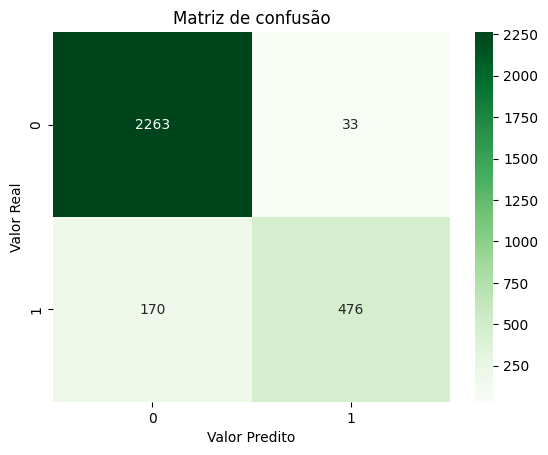

In [49]:
# Melhores hiperparâmetros:  {'n_estimators': 277, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.6610560738295206}
# treinando o random forest classifier
randomforestclassifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=277,
    max_depth=31,
    min_samples_split=4,
    min_samples_leaf=6,
    max_features=0.6610560738295206,
    class_weight=pesos,
    random_state=47
)

rf_treinado, _, _, _ = treinar_modelo(randomforestclassifier, X[features_RFE_randomforest], y, True)

Média da Precisão (Weighted): 93.71%
Média da Revocação (Weighted): 93.70%
Média do F1 Score (Weighted): 93.46%
Precisão x Revocação, Área abaixo da Curva: (92.15%) -> 0.9214930529472126


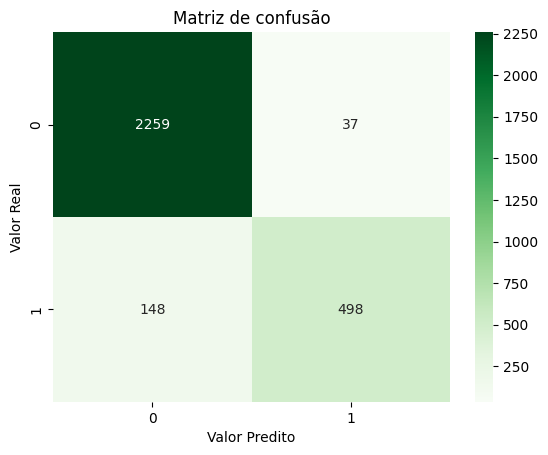

In [16]:
# Melhores hiperparâmetros: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.4112354775681158, 'gamma': 0.09972654226276964}
# treinando o xgboost classifier
xgbclassifier = XGBClassifier(
    n_estimators=227,
    max_depth=5,
    learning_rate=0.4112354775681158,
    gamma=0.09972654226276964,
    random_state=47
)

xgb_treinado, _, y_test, y_pred = treinar_modelo(xgbclassifier, X[features_RFE_xgboost], y, True)

Média da Precisão (Weighted): 93.77%
Média da Revocação (Weighted): 93.67%
Média do F1 Score (Weighted): 93.38%
Precisão x Revocação, Área abaixo da Curva: (92.78%) -> 0.9277823121875933


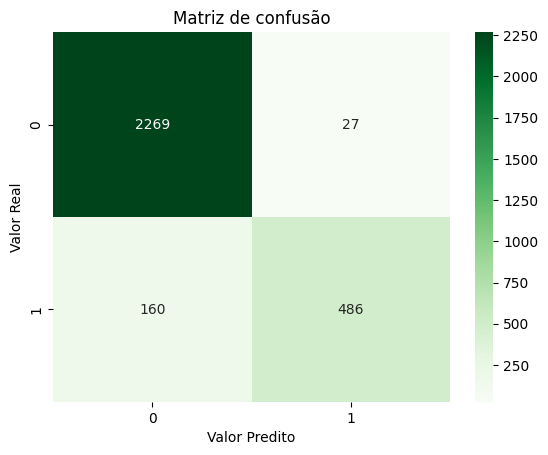

In [48]:
# Melhores hiperparâmetros:  {'n_estimators': 233, 'max_depth': 7, 'learning_rate': 0.11008445645768045, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 0.9996811582073081}
# treinando o gradient boosting classifier
gradientboostingclassifier = GradientBoostingClassifier(
    n_estimators=233,
    max_depth=7,
    learning_rate=0.11008445645768045,
    min_samples_split=13,
    min_samples_leaf=9,
    max_features=0.9996811582073081,
    random_state=47
)

gbc_treinado, _, _, _ = treinar_modelo(gradientboostingclassifier, X[features_RFE_gbc], y, True)

### Modelo escolhido

Escolhemos o XGBoost Classifier pelas razões abaixo:
- Possui uma revocação mais alta e identificou melhor os inadimplentes. 
- Tempo de treinamento do modelo e respectiva tunagem de hiperparâmetros são rápidos, resultando em pouco tempo de atraso na resposta;
- Em produção não utiliza tanto processamento e memória; e
- O arquivo pickle do XGBoost Classifier é o mais leve.

# Aplicação Prática de Negócio
Revisando a performance do modelo escolhido:
- **Média da Precisão (Weighted):** 93.71%
- **Média da Revocação (Weighted):** 93.70%
- **Média do F1 Score (Weighted):** 93.46%
- **Precisão x Revocação, Área abaixo da Curva:** 92.15%

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar 93.70% dos casos. Contudo, o modelo acertou apenas 93.71% dos casos em que ele previu que os clientes não pagariam.

**Inserindo em um contexto para visualizar a aplicabilidade deste modelo no negócio**
- Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, temos a proposta abaixo:

--------------------------------------------------------------------------------
Não conceder o valor de empréstimo solicitado pelos clientes inadimplentes.

--------------------------------------------------------------------------------

Para visualizar os efeitos desta proposta com esta solução utilizando machine learning devemos primeiro selecionar no banco de dados os clientes em que a previsão foi correta de clientes inadimplentes:

In [17]:
y_pred = pd.Series(y_pred)
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] == y_pred]
indices_1 = intersec[intersec == 1].index
X_test_1 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_1, :]
X_test_1

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
1,21,9600,Própria,5,Educação,B,1000,11.14,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,Hipoteca,1,Médico,C,5500,12.87,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
9,21,10000,Própria,6,Empreendimento,D,1600,14.74,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300
12,23,95000,Alugada,2,Empreendimento,A,35000,7.90,0.37,0,...,2.714286,1.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000021,0.000021
15,23,120000,Alugada,0,Educação,A,35000,7.90,0.29,0,...,3.428571,0.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000000,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,24,30000,Hipoteca,4,Médico,D,10000,15.99,0.33,1,...,3.000000,2.000000,10824.456193,9244.618566,6770.406753,63193.286405,59818.228309,46037.084190,0.000133,0.000067
2906,25,36000,Hipoteca,0,Médico,A,5600,7.49,0.16,0,...,6.428571,0.000000,8521.565413,9244.618566,6770.406753,65154.163508,59818.228309,46037.084190,0.000000,0.000111
2909,23,48000,Alugada,7,Consolidação de Dívidas,C,3500,13.98,0.07,0,...,13.714286,1.750000,9221.676127,9567.238806,5814.229899,62525.863089,64680.251173,31495.813457,0.000146,0.000083
2912,23,48562,Alugada,4,Empreendimento,A,3500,8.00,0.07,0,...,13.874857,2.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000082,0.000041


Podemos visualizar que pegamos um dos folds de teste com 498 clientes cuja previsão foram de inadimplentes.

Devemos agora verificar quanto de prejuízo evitamos, assim saberemos a eficácia da não concessão de empréstimo para estes clientes:

In [18]:
prejuizo_evitado = float((X_test_1['valor_emprestimo'].values).sum())
print(f'Evitaríamos o prejuízo de R$ {prejuizo_evitado:.2f}')

Evitaríamos o prejuízo de R$ 5075275.00


Evitamos perder R$ 5.075.275,00 (5 milhões).

Agora, podemos finalmente calcular o saldo bruto:

In [22]:
intersec = y_pred[y_test.reset_index().drop(columns='index', axis=1)['status_emprestimo'] == y_pred]
indices_2 = intersec[intersec == 0].index

# Selecionar as linhas correspondentes no dataset original df (supondo que df é o dataframe original)
X_test_2 = df.reset_index().drop(columns='index', axis=1).iloc[indices_2, :]
X_test_2

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,Alugada,23,Pessoal,D,35000,16.02,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
3,23,65500,Alugada,4,Médico,C,35000,15.23,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,Alugada,8,Médico,C,35000,14.27,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,Própria,2,Empreendimento,A,2500,7.14,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,Alugada,8,Educação,B,35000,12.42,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,23,63816,Alugada,4,Educação,B,3500,9.63,0.05,0,...,18.233143,1.333333,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000063,0.000047
2937,24,65000,Alugada,3,Educação,A,3500,7.74,0.05,0,...,18.571429,1.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000046,0.000046
2938,25,59000,Alugada,3,Médico,D,3500,15.65,0.06,0,...,16.857143,1.500000,10824.456193,9244.618566,5814.229899,63193.286405,59818.228309,31495.813457,0.000051,0.000034
2940,23,30000,Hipoteca,6,Melhoria da Casa,A,6725,6.99,0.22,0,...,4.460967,2.000000,8521.565413,10318.158295,6770.406753,65154.163508,72813.853577,46037.084190,0.000200,0.000100


Obtemos um dos folds de teste com 2259 clientes cuja previsão foi correta, classificando-os como adimplentes.

In [23]:
# multiplicamos o valor concedido por 1 + juros para obter o valor total que aquele cliente retornou
valor_concedido = float((X_test_2['valor_emprestimo'].values).sum())
print(f'Concedemos R$ {valor_concedido:.2f}')

Concedemos R$ 21678675.00


In [24]:
lucro_bruto = float((X_test_2['valor_emprestimo'].values*(X_test_2['taxa_juros_emprestimo'].values/100)).sum())
print(f'Obteríamos o lucro BRUTO de R$ {lucro_bruto:.2f}')

Obteríamos o lucro BRUTO de R$ 2594183.73


In [25]:
# retorno total
retorno_total = float(valor_concedido + lucro_bruto)
print(f'Retorno total das concessões de empréstimo: R$ {retorno_total:.2f}')

Retorno total das concessões de empréstimo: R$ 24272858.73


- Concedemos R$ 21.678.695,00 para os clientes (21.6 milhões)

- Nos retornou um **lucro BRUTO** de: R$ 2.594.183,73 (2.6 milhões)

- Possuímos um saldo até o momento de: R$ 24.272.858.73 (24.2 milhões)

Neste momento é importante verificar quanto deixaríamos de ganhar por prever erradamente os clientes que pagariam, classificando-os como inadimplentes:

In [26]:
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] != y_pred]
indices_3 = intersec[intersec == 1].index
X_test_3 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_3, :]
X_test_3

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
157,26,200000,Hipoteca,4,Educação,C,15000,14.790000,0.07,0,...,13.333333,1.333333,9221.676127,9481.100478,6770.406753,62525.863089,63593.200957,46037.084190,0.000020,0.000015
230,25,90000,Alugada,9,Médico,B,25000,10.990000,0.28,0,...,3.600000,2.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000100,0.000044
246,23,70550,Alugada,3,Médico,F,25000,19.040001,0.30,1,...,2.822000,0.750000,15207.359813,9244.618566,5814.229899,79000.032710,59818.228309,31495.813457,0.000043,0.000057
248,26,175000,Hipoteca,3,Empreendimento,A,2600,8.900000,0.01,0,...,67.307692,0.750000,8521.565413,9568.263066,6770.406753,65154.163508,65236.276083,46037.084190,0.000017,0.000023
268,25,162000,Hipoteca,5,Consolidação de Dívidas,E,25000,16.000000,0.15,1,...,6.480000,1.666667,12913.607955,9567.238806,6770.406753,70247.246591,64680.251173,46037.084190,0.000031,0.000019
301,25,168000,Hipoteca,2,Pessoal,B,35000,10.650000,0.21,0,...,4.800000,1.000000,9962.653301,9586.847630,6770.406753,65034.454516,65187.707459,46037.084190,0.000012,0.000012
361,23,287000,Alugada,3,Educação,B,24250,12.530000,0.08,0,...,11.835052,1.000000,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000010,0.000010
365,24,48000,Alugada,4,Empreendimento,D,24000,16.290001,0.50,1,...,2.000000,2.000000,10824.456193,9568.263066,5814.229899,63193.286405,65236.276083,31495.813457,0.000083,0.000042
452,24,76597,Alugada,5,Educação,B,22000,9.250000,0.29,0,...,3.481682,2.500000,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000065,0.000026
495,22,75000,Alugada,2,Educação,B,21000,10.000000,0.28,0,...,3.571429,0.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000027,0.000040


Obtemos um dos folds de teste com 37 clientes cuja previsão foi errada, classificando-os como inadimplentes.

In [27]:
# Somente o valor do empréstimo multiplicado pela taxa de juros de cada cliente
prejuizo_falsos_positivos = float((X_test_3['valor_emprestimo'].values*(X_test_3['taxa_juros_emprestimo'].values/100)).sum())
print(f'Deixaríamos de ganhar com os falsos positivos: R$ {prejuizo_falsos_positivos:.2f}')

Deixaríamos de ganhar com os falsos positivos: R$ 45169.95


Como não concederíamos empréstimos para os clientes indevidamente classificados como inadimplentes (falsos positivos), devemos somar ao prejuízo a quantia relativa ao juros sobre o empréstimo que não ganharíamos destes clientes: R$ 45.169,00 (45 mil)

Devemos agora verificar os clientes que não pagariam e foram classificados como adimplentes:

In [19]:
# Filtrar os índices dos falsos negativos
intersec = y_pred[(y_test.reset_index(drop=True) == 1) & (y_pred == 0)]
indices_4 = intersec[intersec == 0].index
X_test_4 = df.iloc[indices_4]
X_test_4

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
78,22,70000,Alugada,4,Educação,C,27500,13.06,0.39,1,...,2.545455,1.333333,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000057,0.000043
88,25,221004,Hipoteca,6,Consolidação de Dívidas,D,11900,14.42,0.05,1,...,18.571765,2.000000,10824.456193,9567.238806,6770.406753,63193.286405,64680.251173,46037.084190,0.000027,0.000014
93,25,12600,Própria,3,Pessoal,C,1750,13.61,0.14,0,...,7.200000,1.000000,9221.676127,9586.847630,6200.190887,62525.863089,65187.707459,41373.782824,0.000238,0.000238
126,23,52000,Alugada,1,Pessoal,C,25000,13.22,0.48,0,...,2.080000,0.500000,9221.676127,9586.847630,5814.229899,62525.863089,65187.707459,31495.813457,0.000019,0.000038
128,22,53000,Alugada,5,Educação,C,25000,13.43,0.47,1,...,2.120000,1.250000,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000094,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,21,35004,Própria,0,Educação,D,3000,15.58,0.09,0,...,11.668000,0.000000,10824.456193,9481.100478,6200.190887,63193.286405,63593.200957,41373.782824,0.000000,0.000086
2889,25,42000,Alugada,0,Empreendimento,A,3500,5.42,0.08,0,...,12.000000,0.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000000,0.000095
2923,22,55000,Alugada,7,Médico,B,3500,9.99,0.06,0,...,15.714286,2.333333,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000127,0.000055
2925,26,51000,Alugada,3,Consolidação de Dívidas,D,3500,13.24,0.07,1,...,14.571429,0.750000,10824.456193,9567.238806,5814.229899,63193.286405,64680.251173,31495.813457,0.000059,0.000078


Obtemos um dos folds de teste com 145 clientes cuja previsão foi errada, classificando-os como adimplentes.

In [20]:
prejuizo_falsos_negativos = float((X_test_4['valor_emprestimo'].values).sum())
print(f'Os falsos negativos resultariam em um prejuízo de R$ {prejuizo_falsos_negativos:.2f}')

Os falsos negativos resultariam em um prejuízo de R$ 1297600.00


Com os falsos negativos obtemos um prejuízo de: R$ 1.297.600,00

Podemos calcular o prejuízo total:

In [28]:
prejuizo_total = float(prejuizo_falsos_positivos + prejuizo_falsos_negativos)
print(f'Teríamos um prejuízo total de R% {prejuizo_total:.2f}')

Teríamos um prejuízo total de R% 1342769.95


O modelo retornou uma perda devido à classificações erradas de: R$ 1.134.276,95 (1.2 milhão)

Nesta penúltima etapa, verificamos o **total líquido**, sendo os ganhos com classificações corretas de adimplentes subtraído da classificação incorreta de clientes:

In [29]:
saldo_liquido = float(lucro_bruto - prejuizo_total)
print(f'Possuímos um total LÍQUIDO de R$ {saldo_liquido:.2f}')

Possuímos um total LÍQUIDO de R$ 1251413.78


Terminaríamos com um total líquido de: R$ 1.251.413,78 (1.2 milhão)

Agora verificaremos o nosso saldo final:

In [31]:
saldo_final = retorno_total - prejuizo_total
print(f'Possuímos um saldo final de: R$ {saldo_final:.2f}')

Possuímos um saldo final de: R$ 22930088.78


## Resultado
- Evitaríamos perder: R$ 5.075.275,00 (5 milhões).

- **Lucro Bruto** de: R$ 2.594.183,73 (2.6 milhões)

- Perderíamos: R$ 1.134.276,95 (1.1 milhão)

- Gerando um **Total Líquido** de: R$ 1.251.413,78 (1.3 milhão)

- No início concedemos R$ 21.649.350,00 (21.6 milhões) e terminamos com o saldo final de: R$ 22.930.088,78 (23 milhões)

Isso tudo com um baixo custo computacional e também com praticidade na manutenção do modelo para posterior melhorias.

O cenário ideal seria reduzir os falsos negativos à zero, entretanto, reduzir o threshold faz com que os falsos positivos aumentem substancialmente enquanto os falsos negativos diminuem em pequena quantia. Aumentar a revocação e diminuir a precisão pode ter custos maiores futuramente a depender da decisão de conceder empréstimos maiores e pode não ser mais viável um ajuste visando aumentar a revocação.

~~2. O cenário ideal seria reduzir os falsos negativos à zero. Assim o número de falsos positivos aumentarão substancialmente ao diminuir o threshold, gerando perdas significativas de dinheiro, entretanto, vimos na EDA que a maior taxa de juros de empréstimo está na casa de 22.5% e o maior empréstimo fornecido é de R$ 35.000. Utilizando estes dois valores podemos verificar o quanto um **cliente inadimplente** acarreta de prejuízo a mais que um **cliente adimplente** que o modelo previu que não pagaria:~~

In [49]:
# cenário ideal 2
prejuizo_1_cliente_inadimplente = 35000
prejuizo_1_cliente_adimplente = 35000 * 0.225

proporcao_prejuizos = prejuizo_1_cliente_inadimplente / prejuizo_1_cliente_adimplente
proporcao_prejuizos

4.444444444444445

Confirmamos que a classificação errada de um cliente em potencial, porém inadimplente pode resultar no mesmo prejuízo que a classificação errada de 4 clientes em potencial que pagariam normalmente.

## Exportando o modelo final

In [50]:
# cenário ideal 1 -> partir para o deploy com o xgboost hipertunado com optuna
# Serializando o modelo em um arquivo pickle
with open(f'xgboostclassifier-{str(datetime.date.today())}.pkl', mode='wb') as f:
    pickle.dump(xgb_treinado, f)

In [ ]:
# cenário ideal 2 -> criar a função que treina o modelo com stratifiedkfold, melhor threshold e cross_validate